In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import os

from glob import glob
from datetime import datetime
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist

from utils import fileio
from utils import visualise
from utils import geometry
from utils import matrices
from utils import cellmatch
from source import segmentation_hand

In [2]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],'k',marker ='o',markersize=1)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 7,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high


In [3]:
def plot_cmap(plot_variable, cmap, save_dir, stretch, frame,title, c_label, A,B,C,R, cc ):
    #plot_variable=cell_circ_0 ###Set variable to plot

    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

    ## For colormap of continuous data
    polys=plot_polys(C, R, cc)
    polys.set_facecolor('black')
    ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0.5, 1.5)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax, extend='both')
    cbar.ax.set_ylabel(c_label, rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_cell_id(cc)

    ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(save_dir+'/'+title+'.png', dpi=300)

In [4]:
o_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output'
#folders=glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20230203_1_IN_BFPCAAX-CheHis_us_*\\*')
cell_map=np.loadtxt('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\20230203_us_map_cells_stretch.csv', delimiter=',',skiprows=1 )
cell_map_post=np.loadtxt('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\20230203_us_map_cells_post_stretch.csv', delimiter=',',skiprows=1 )
stage_pos=np.loadtxt('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\stage_pos.csv', delimiter=',',skiprows=1 )
save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental'
pref_area_f='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis\\Output\\20230203_1_IN_BFPCAAX-CheHis_us_0p5_SP_fr1\\2023-06-29_18-37-43\\Data\\20230203_1_IN_BFPCAAX-CheHis_us_0p5_SP_fr1_pref_area.txt'
with open(pref_area_f,"r") as f:
        pref_area=float(f.readline())
pixel_size=1024
micron_size=551.49

exp_id='20230203_1_IN_BFPCAAX-CheHis_us'



In [5]:

tm_spot_dat=pd.read_csv(save_dir+'/20230203_1_relax_spots.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv(save_dir+'/20230203_1_relax_tracks.csv', skiprows=[1,2,3])

tm_dat=tm_spot_dat



i=0
cell_id=[]
tm_id=[]
track_id=[]

cc_orig=[]
R_orig=[]
for folder in sorted(glob(o_folder+'\\'+exp_id+'_8p6*_*P_fr*')):
    mat_dir=glob(folder+'\\*\\Matrices')[0]
    A  = np.loadtxt(glob(mat_dir+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
    B  = np.loadtxt(glob(mat_dir+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
    C  = np.loadtxt(glob(mat_dir+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
    R  = np.loadtxt(glob(mat_dir+'/*Matrix_R*.txt')[0]) # Coordinates of vertices
    
    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)
    cc_orig.append(cell_centres)
    R_orig.append(R)


    tm_dat_fr_a=tm_dat[tm_dat.FRAME==i]
    tm_centres=np.transpose(np.vstack(((tm_dat_fr_a.POSITION_X-np.mean(tm_dat_fr_a.POSITION_X))*0.89, (-tm_dat_fr_a.POSITION_Y-np.mean(-tm_dat_fr_a.POSITION_Y))*0.89)))
    if i in [0,1,2]:
        centres=np.array([cell_centres[x] for x in cell_map_post[:,i].astype(int)])
        cc=centres-np.mean(centres, axis=0)  
    elif i==5:
        centres=np.array([cell_centres[x] for x in cell_map_post[:,3].astype(int)])
        cc=centres-np.mean(centres, axis=0)
    elif i==8:
        centres=np.array([cell_centres[x] for x in cell_map_post[:,4].astype(int)])
        cc=centres-np.mean(centres, axis=0)
    else:
        cc=cell_centres-np.mean(cell_centres, axis=0)

    # plt.scatter(tm_centres[:,0], tm_centres[:,1])
    # plt.scatter(cc[:,0], cc[:,1])
    # plt.show()

    min_id=[]
    for k in range(len(cc)):
        min_id.append(np.where(cdist(cc, tm_centres)[k]==min(cdist(cc, tm_centres)[k]))[0][0])

        
    cell_id.append(np.linspace(0, len(cc)-1, len(cc)))
    tm_id.append(min_id)
    track_id.append(tm_dat_fr_a.iloc[min_id].TRACK_ID)


    i+=1


ids_4800=pd.DataFrame(data=np.transpose(np.vstack((cell_id[0], tm_id[0], track_id[0]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_5100=pd.DataFrame(data=np.transpose(np.vstack((cell_id[1], tm_id[1], track_id[1]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_5400=pd.DataFrame(data=np.transpose(np.vstack((cell_id[2], tm_id[2], track_id[2]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna() 
ids_5700=pd.DataFrame(data=np.transpose(np.vstack((cell_id[3], tm_id[3], track_id[3]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_6000=pd.DataFrame(data=np.transpose(np.vstack((cell_id[4], tm_id[4], track_id[4]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_6300=pd.DataFrame(data=np.transpose(np.vstack((cell_id[5], tm_id[5], track_id[5]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna() 
ids_6600=pd.DataFrame(data=np.transpose(np.vstack((cell_id[6], tm_id[6], track_id[6]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_6900=pd.DataFrame(data=np.transpose(np.vstack((cell_id[7], tm_id[7], track_id[7]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna()
ids_7200=pd.DataFrame(data=np.transpose(np.vstack((cell_id[8], tm_id[8], track_id[8]))).astype(int), columns=['id', 'tm_index', 'track_id']).dropna() 

In [8]:
id_map_relax=ids_4800.merge(ids_5100, on='track_id', how='inner', suffixes=['_4800','_5100'])\
.merge(ids_5400, on='track_id', how='inner', suffixes=['', '_5400'])\
.merge(ids_5700, on='track_id', how='inner', suffixes=['', '_5700'])\
.merge(ids_6000, on='track_id', how='inner', suffixes=['', '_6000'])\
.merge(ids_6300, on='track_id', how='inner', suffixes=['', '_6300'])\
.merge(ids_6600, on='track_id', how='inner', suffixes=['', '_6600'])\
.merge(ids_6900, on='track_id', how='inner', suffixes=['', '_6900'])\
.merge(ids_7200, on='track_id', how='inner', suffixes=['', '_7200'])\
.merge(tm_track_dat.TRACK_ID, left_on='track_id', right_on='TRACK_ID')


id_map_relax=id_map_relax.rename(columns={'id':'id_5400','tm_index': 'tm_index_5400'})
np.unique(id_map_relax.id_4800)[np.where(np.unique(id_map_relax.id_4800, return_counts=True)[1]>1)[0]]

array([], dtype=int32)

In [9]:
A_0, B_0, C_0, R_0, cc_0,cells_0, cell_edges_0=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'0p5', '1', pixel_size, micron_size, cell_map[:,0])
cell_areas_0=geometry.get_areas(A_0, B_0, R_0)
cell_perimeters_0=geometry.get_perimeters(A_0, B_0, R_0)

A_300, B_300, C_300, R_300, cc_300, cells_300, cell_edges_300=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'1p0', '1', pixel_size, micron_size, cell_map[:,1])
cell_areas_300=geometry.get_areas(A_300, B_300, R_300)
cell_perimeters_300=geometry.get_perimeters(A_300, B_300, R_300)

A_600, B_600, C_600, R_600, cc_600, cells_600, cell_edges_600=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'1p5', '1', pixel_size, micron_size, cell_map[:,2])
cell_areas_600=geometry.get_areas(A_600, B_600, R_600)
cell_perimeters_600=geometry.get_perimeters(A_600, B_600, R_600)

A_900, B_900, C_900, R_900, cc_900, cells_900, cell_edges_900=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'2p0', '1', pixel_size, micron_size, cell_map[:,3])
cell_areas_900=geometry.get_areas(A_900, B_900, R_900)
cell_perimeters_900=geometry.get_perimeters(A_900, B_900, R_900)

A_1200, B_1200, C_1200, R_1200, cc_1200, cells_1200, cell_edges_1200=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'2p5', '1', pixel_size, micron_size, cell_map[:,4])
cell_areas_1200=geometry.get_areas(A_1200, B_1200, R_1200)
cell_perimeters_1200=geometry.get_perimeters(A_1200, B_1200, R_1200)

A_1500, B_1500, C_1500, R_1500, cc_1500, cells_1500, cell_edges_1500=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'3p0', '1', pixel_size, micron_size, cell_map[:,5])
cell_areas_1500=geometry.get_areas(A_1500, B_1500, R_1500)
cell_perimeters_1500=geometry.get_perimeters(A_1500, B_1500, R_1500)

A_1800, B_1800, C_1800, R_1800, cc_1800, cells_1800, cell_edges_1800=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'3p5', '1', pixel_size, micron_size, cell_map[:,6])
cell_areas_1800=geometry.get_areas(A_1800, B_1800, R_1800)
cell_perimeters_1800=geometry.get_perimeters(A_1800, B_1800, R_1800)

A_2100, B_2100, C_2100, R_2100, cc_2100, cells_2100, cell_edges_2100=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'4p0', '1', pixel_size, micron_size, cell_map[:,7])
cell_areas_2100=geometry.get_areas(A_2100, B_2100, R_2100)
cell_perimeters_2100=geometry.get_perimeters(A_2100, B_2100, R_2100)

A_2400, B_2400, C_2400, R_2400, cc_2400, cells_2400, cell_edges_2400=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'4p5', '1', pixel_size, micron_size, cell_map[:,8])
cell_areas_2400=geometry.get_areas(A_2400, B_2400, R_2400)
cell_perimeters_2400=geometry.get_perimeters(A_2400, B_2400, R_2400)

A_2700, B_2700, C_2700, R_2700, cc_2700, cells_2700, cell_edges_2700=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'5p0', '1', pixel_size, micron_size, cell_map[:,9])
cell_areas_2700=geometry.get_areas(A_2700, B_2700, R_2700)
cell_perimeters_2700=geometry.get_perimeters(A_2700, B_2700, R_2700)

A_3000, B_3000, C_3000, R_3000, cc_3000, cells_3000, cell_edges_3000=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'5p5', '1', pixel_size, micron_size, cell_map[:,10])
cell_areas_3000=geometry.get_areas(A_3000, B_3000, R_3000)
cell_perimeters_3000=geometry.get_perimeters(A_3000, B_3000, R_3000)

A_3300, B_3300, C_3300, R_3300, cc_3300,cells_3300, cell_edges_3300=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'6p0', '1', pixel_size, micron_size, cell_map[:,11])
cell_areas_3300=geometry.get_areas(A_3300, B_3300, R_3300)
cell_perimeters_3300=geometry.get_perimeters(A_3300, B_3300, R_3300)

A_3600, B_3600, C_3600, R_3600, cc_3600, cells_3600, cell_edges_3600=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'6p5', '1', pixel_size, micron_size, cell_map[:,12])
cell_areas_3600=geometry.get_areas(A_3600, B_3600, R_3600)
cell_perimeters_3600=geometry.get_perimeters(A_3600, B_3600, R_3600)

A_3900, B_3900, C_3900, R_3900, cc_3900, cells_3900, cell_edges_3900=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'7p0', '1', pixel_size, micron_size, cell_map[:,13])
cell_areas_3900=geometry.get_areas(A_3900, B_3900, R_3900)
cell_perimeters_3900=geometry.get_perimeters(A_3900, B_3900, R_3900)

A_4200, B_4200, C_4200, R_4200, cc_4200, cells_4200, cell_edges_4200=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'7p5', '1', pixel_size, micron_size, cell_map[:,14])
cell_areas_4200=geometry.get_areas(A_4200, B_4200, R_4200)
cell_perimeters_4200=geometry.get_perimeters(A_4200, B_4200, R_4200)

A_4500, B_4500, C_4500, R_4500, cc_4500, cells_4500, cell_edges_4500=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'8p0', '1', pixel_size, micron_size, cell_map[:,15])
cell_areas_4500=geometry.get_areas(A_4500, B_4500, R_4500)
cell_perimeters_4500=geometry.get_perimeters(A_4500, B_4500, R_4500)

A_4800, B_4800, C_4800, R_4800, cc_4800, cells_4800, cell_edges_4800=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '1', pixel_size, micron_size, cell_map[:,16])
cell_areas_4800=geometry.get_areas(A_4800, B_4800, R_4800)
cell_perimeters_4800=geometry.get_perimeters(A_4800, B_4800, R_4800)

A_5100, B_5100, C_5100, R_5100, cc_5100, cells_5100, cell_edges_5100=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '6', pixel_size, micron_size, cell_map_post[:,1])
cell_areas_5100=geometry.get_areas(A_5100, B_5100, R_5100)
cell_perimeters_5100=geometry.get_perimeters(A_5100, B_5100, R_5100)

A_5400, B_5400, C_5400, R_5400, cc_5400, cells_5400, cell_edges_5400=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '11', pixel_size, micron_size, cell_map_post[:,2])
cell_areas_5400=geometry.get_areas(A_5400, B_5400, R_5400)
cell_perimeters_5400=geometry.get_perimeters(A_5400, B_5400, R_5400)

A_5700, B_5700, C_5700, R_5700, cc_5700, cells_5700, cell_edges_5700=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '16', pixel_size, micron_size, id_map_relax.id_5700)
cell_areas_5700=geometry.get_areas(A_5700, B_5700, R_5700)
cell_perimeters_5700=geometry.get_perimeters(A_5700, B_5700, R_5700)

A_6000, B_6000, C_6000, R_6000, cc_6000, cells_6000, cell_edges_6000=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '21', pixel_size, micron_size, id_map_relax.id_6000)
cell_areas_6000=geometry.get_areas(A_6000, B_6000, R_6000)
cell_perimeters_6000=geometry.get_perimeters(A_6000, B_6000, R_6000)

A_6300, B_6300, C_6300, R_6300, cc_6300, cells_6300, cell_edges_6300=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '26', pixel_size, micron_size, cell_map_post[:,3])
cell_areas_6300=geometry.get_areas(A_6300, B_6300, R_6300)
cell_perimeters_6300=geometry.get_perimeters(A_6300, B_6300, R_6300)

A_6600, B_6600, C_6600, R_6600, cc_6600, cells_6600, cell_edges_6600=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '31', pixel_size, micron_size, id_map_relax.id_6600)
cell_areas_6600=geometry.get_areas(A_6600, B_6600, R_6600)
cell_perimeters_6600=geometry.get_perimeters(A_6600, B_6600, R_6600)

A_6900, B_6900, C_6900, R_6900, cc_6900, cells_6900, cell_edges_6900=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '36', pixel_size, micron_size, id_map_relax.id_6900)
cell_areas_6900=geometry.get_areas(A_6900, B_6900, R_6900)
cell_perimeters_6900=geometry.get_perimeters(A_6900, B_6900, R_6900)

A_7200, B_7200, C_7200, R_7200, cc_7200, cells_7200, cell_edges_7200=cellmatch.reindex_data_tm(o_folder,exp_id, save_dir,'8p6', '41', pixel_size, micron_size, cell_map_post[:,4])
cell_areas_7200=geometry.get_areas(A_7200, B_7200, R_7200)
cell_perimeters_7200=geometry.get_perimeters(A_7200, B_7200, R_7200)

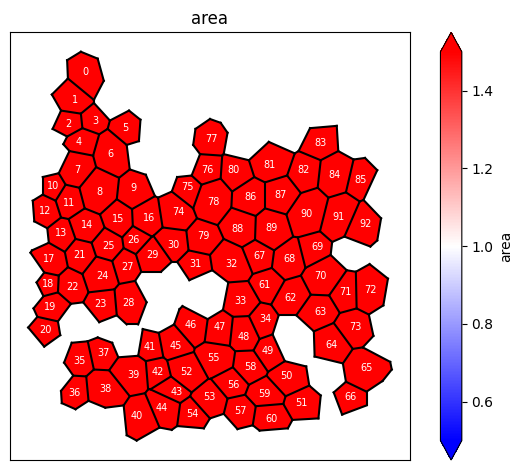

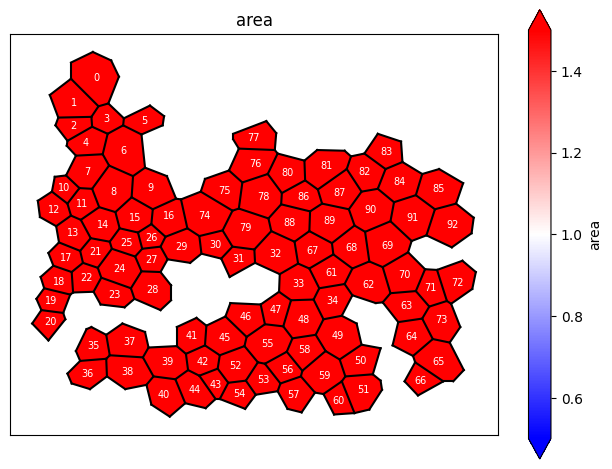

In [10]:
plot_cmap(cell_areas_0, 'bwr', save_dir,'0p5', '1','area', 'area', A_0,B_0,C_0,R_0, cc_0 )
plot_cmap(cell_areas_5700, 'bwr', save_dir,'8p6', '16','area', 'area', A_5700,B_5700,C_5700,R_5700, cc_5700 )

In [11]:
cc_x_stretch=np.transpose(np.vstack((cc_0[:,0], cc_300[:,0], cc_600[:,0], cc_900[:,0], cc_1200[:,0], cc_1500[:,0], cc_1800[:,0], cc_2100[:,0], cc_2400[:,0], cc_2700[:,0], cc_3000[:,0], cc_3300[:,0],cc_3600[:,0], cc_3900[:,0], cc_4200[:,0], cc_4500[:,0], cc_4800[:,0])))
cc_y_stretch=np.transpose(np.vstack((cc_0[:,1], cc_300[:,1], cc_600[:,1], cc_900[:,1], cc_1200[:,1], cc_1500[:,1], cc_1800[:,1], cc_2100[:,1], cc_2400[:,1], cc_2700[:,1], cc_3000[:,1], cc_3300[:,1],cc_3600[:,1], cc_3900[:,1], cc_4200[:,1], cc_4500[:,1], cc_4800[:,1])))
R_stretch=[R_0, R_300, R_600, R_900, R_1200, R_1500, R_1800, R_2100, R_2400, R_2700, R_3000, R_3300, R_3600, R_3900, R_4200, R_4500, R_4800]
cc_x_post=np.transpose(np.vstack((cc_4800[:,0], cc_5100[:,0], cc_5400[:,0], cc_6300[:,0], cc_7200[:,0])))
cc_y_post=np.transpose(np.vstack((cc_4800[:,1], cc_5100[:,1], cc_5400[:,1], cc_6300[:,1], cc_7200[:,1])))
R_post=[R_4800, R_5100, R_5400, R_6300, R_7200]


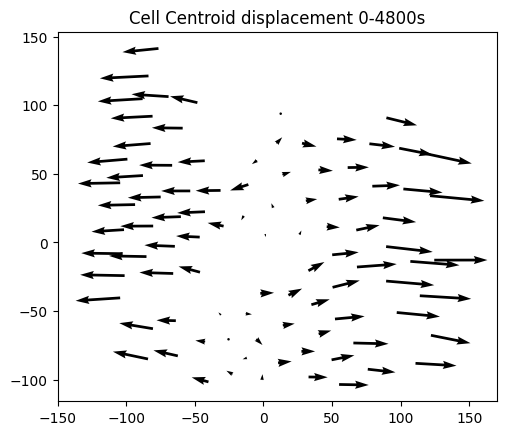

In [36]:
dx=(cc_x_stretch[:,-1]-cc_x_stretch[:,0])-np.mean(cc_x_stretch[:,-1]-cc_x_stretch[:,0])
dy=(cc_y_stretch[:,-1]-cc_y_stretch[:,0])-np.mean(cc_y_stretch[:,-1]-cc_y_stretch[:,0])
plt.quiver(cc_x_stretch[:,0],cc_y_stretch[:,0], dx, dy,units='xy', angles='xy', scale=1, zorder=10)
plt.gca().set_aspect('equal')
plt.xlim(-150,170)
plt.title('Cell Centroid displacement 0-4800s')
plt.savefig(save_dir+'/inc_stretch_quiver.png', dpi=300)

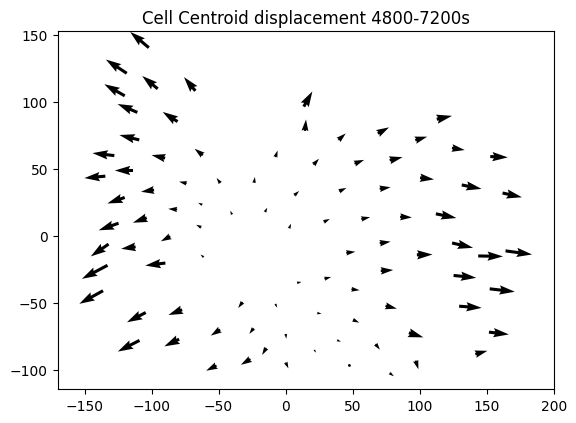

In [37]:
dx_r=(cc_x_post[:,-1]-cc_x_post[:,0])-np.mean(cc_x_post[:,-1]-cc_x_post[:,0])
dy_r=(cc_y_post[:,-1]-cc_y_post[:,0])-np.mean(cc_y_post[:,-1]-cc_y_post[:,0])
plt.quiver(cc_x_post[:,0],cc_y_post[:,0], dx_r, dy_r,units='xy', angles='xy', scale=1, zorder=10)
plt.gca().set_aspect('equal')
plt.xlim(-170,200)
plt.title('Cell Centroid displacement 4800-7200s')
plt.savefig(save_dir+'/inc_relax_quiver.png', dpi=300)

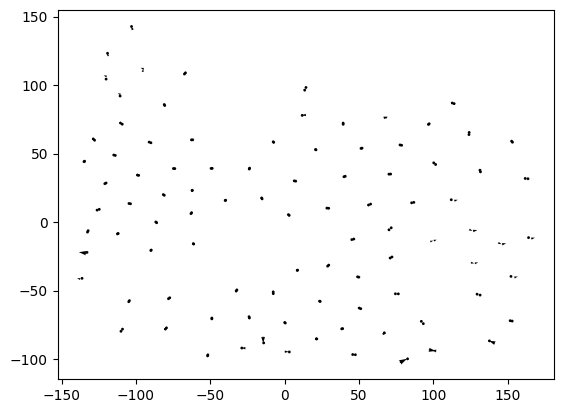

In [50]:
dx_r=(cc_x_post[:,1]-cc_x_post[:,0])-np.mean(cc_x_post[:,1]-cc_x_post[:,0])
dy_r=(cc_y_post[:,1]-cc_y_post[:,0])-np.mean(cc_y_post[:,1]-cc_y_post[:,0])
plt.quiver(cc_4800[:,0],cc_4800[:,1], (cc_5100-cc_4800)[0], (cc_5100-cc_4800)[0],units='xy', angles='xy', scale=1, zorder=10)


In [18]:
import cv2

In [48]:
print(cv2.estimateAffine2D(cc_0, cc_4800, method=cv2.RANSAC, refineIters=0)[0])
print(cv2.estimateAffine2D(cc_0, cc_4800, method=cv2.LMEDS,refineIters=0)[0])

# print(cv2.estimateAffine2D(cc_4800, cc_7200, method=cv2.RANSAC, refineIters=0)[0])
# print(cv2.estimateAffine2D(cc_4800, cc_7200, method=cv2.LMEDS,refineIters=0)[0])

cc_o_4800=np.array([cc_orig[0][x]*(micron_size/pixel_size) for x in cell_map_post[:,0].astype(int)])
cc_o_5100=np.array([cc_orig[1][x]*(micron_size/pixel_size) for x in cell_map_post[:,1].astype(int)])
cc_o_5400=np.array([cc_orig[2][x]*(micron_size/pixel_size) for x in cell_map_post[:,2].astype(int)])
cc_o_5700=np.array([cc_orig[3][x]*(micron_size/pixel_size) for x in id_map_relax.id_5700])
cc_o_6000=np.array([cc_orig[4][x]*(micron_size/pixel_size) for x in id_map_relax.id_6000])
cc_o_6300=np.array([cc_orig[5][x]*(micron_size/pixel_size) for x in cell_map_post[:,-2].astype(int)])
cc_o_6600=np.array([cc_orig[6][x]*(micron_size/pixel_size) for x in id_map_relax.id_6600])
cc_o_6900=np.array([cc_orig[7][x]*(micron_size/pixel_size) for x in id_map_relax.id_6900])
cc_o_7200=np.array([cc_orig[-1][x]*(micron_size/pixel_size) for x in cell_map_post[:,-1].astype(int)])

print("\n")
#print(cv2.estimateAffine2D(cc_o_4800, cc_o_5100, method=cv2.RANSAC, refineIters=0)[0])
print(cv2.estimateAffine2D(cc_o_4800, cc_o_5100, method=cv2.LMEDS,refineIters=0)[0])
#print(cv2.estimateAffine2D(cc_o_5100, cc_o_5400, method=cv2.RANSAC, refineIters=0)[0])
print(cv2.estimateAffine2D(cc_o_5100, cc_o_5400, method=cv2.LMEDS,refineIters=0)[0])
#print(cv2.estimateAffine2D(cc_o_5400, cc_o_5700, method=cv2.RANSAC, refineIters=0)[0])
print(cv2.estimateAffine2D(cc_o_5400, cc_o_5700, method=cv2.LMEDS,refineIters=0)[0])
#print(cv2.estimateAffine2D(cc_o_6300, cc_o_7200, method=cv2.RANSAC, refineIters=0)[0])
print(cv2.estimateAffine2D(cc_o_5700, cc_o_6000, method=cv2.LMEDS,refineIters=0)[0])
print(cv2.estimateAffine2D(cc_o_6000, cc_o_6300, method=cv2.LMEDS,refineIters=0)[0])
print(cv2.estimateAffine2D(cc_o_6300, cc_o_6600, method=cv2.LMEDS,refineIters=0)[0])
print(cv2.estimateAffine2D(cc_o_6600, cc_o_6900, method=cv2.LMEDS,refineIters=0)[0])
print(cv2.estimateAffine2D(cc_o_6900, cc_o_7200, method=cv2.LMEDS,refineIters=0)[0])
print("\n")
print(cv2.estimateAffine2D(cc_o_4800, cc_o_7200, method=cv2.RANSAC, refineIters=0)[0])
print(cv2.estimateAffine2D(cc_o_4800, cc_o_7200, method=cv2.LMEDS,refineIters=0)[0])


[[ 1.33353525 -0.03740042  0.09900386]
 [ 0.00136307  0.99658705  1.01196206]]
[[ 1.30859747 -0.07031467  1.66917321]
 [-0.01185855  0.98287893  0.67393451]]


[[ 1.01490746e+00 -4.63442050e-03 -4.97656346e+00]
 [-3.74035306e-03  1.00386870e+00 -2.82583295e-01]]
[[ 1.01461603e+00 -1.70122059e-03 -4.40132595e+00]
 [ 8.74858564e-03  9.94365770e-01 -3.74317264e-01]]
[[ 1.00968733e+00  7.94701515e-03 -7.58983268e+00]
 [ 2.10060642e-03  1.01031004e+00 -4.06861023e+00]]
[[ 1.02724449e+00  1.28161236e-02 -1.37734064e+01]
 [-4.77479604e-03  1.00601220e+00  1.33310584e-01]]
[[ 1.02068996e+00  8.92554779e-03 -1.02798346e+01]
 [-2.61489220e-03  1.00419886e+00 -2.98175850e-01]]
[[ 1.01834722e+00 -2.54336331e-03 -5.97092436e+00]
 [-1.12596823e-02  1.00369668e+00  2.35356584e+00]]
[[ 0.99908876 -0.00720431  2.67691809]
 [-0.00412166  1.00486081  0.64269862]]
[[ 1.01487676 -0.00402368 -2.39286935]
 [ 0.00402243  1.00992207 -2.50056599]]


[[ 1.10999190e+00 -2.86316948e-02 -3.76419282e+01]
 [-2.783171

In [65]:
np.array(cc_t)[1:].shape

(8, 93, 2)

In [94]:
F=[]
dr=[]
F.append(cv2.estimateAffine2D(cc_o_4800, cc_o_5100, method=cv2.LMEDS,refineIters=0)[0][:,:2])
dr.append(cv2.estimateAffine2D(cc_o_4800, cc_o_5100, method=cv2.LMEDS,refineIters=0)[0][:,2])

F.append(cv2.estimateAffine2D(cc_o_5100, cc_o_5400, method=cv2.LMEDS,refineIters=0)[0][:,:2])
dr.append(cv2.estimateAffine2D(cc_o_5100, cc_o_5400, method=cv2.LMEDS,refineIters=0)[0][:,2])

F.append(cv2.estimateAffine2D(cc_o_5400, cc_o_5700, method=cv2.LMEDS,refineIters=0)[0][:,:2])
dr.append(cv2.estimateAffine2D(cc_o_5400, cc_o_5700, method=cv2.LMEDS,refineIters=0)[0][:,2])

F.append(cv2.estimateAffine2D(cc_o_5700, cc_o_6000, method=cv2.LMEDS,refineIters=0)[0][:,:2])
dr.append(cv2.estimateAffine2D(cc_o_5700, cc_o_6000, method=cv2.LMEDS,refineIters=0)[0][:,2])

F.append(cv2.estimateAffine2D(cc_o_6000, cc_o_6300, method=cv2.LMEDS,refineIters=0)[0][:,:2])
dr.append(cv2.estimateAffine2D(cc_o_6000, cc_o_6300, method=cv2.LMEDS,refineIters=0)[0][:,2])

F.append(cv2.estimateAffine2D(cc_o_6300, cc_o_6600, method=cv2.LMEDS,refineIters=0)[0][:,:2])
dr.append(cv2.estimateAffine2D(cc_o_6300, cc_o_6600, method=cv2.LMEDS,refineIters=0)[0][:,2])

F.append(cv2.estimateAffine2D(cc_o_6600, cc_o_6900, method=cv2.LMEDS,refineIters=0)[0][:,:2])
dr.append(cv2.estimateAffine2D(cc_o_6600, cc_o_6900, method=cv2.LMEDS,refineIters=0)[0][:,2])

F.append(cv2.estimateAffine2D(cc_o_6900, cc_o_7200, method=cv2.LMEDS,refineIters=0)[0][:,:2])
dr.append(cv2.estimateAffine2D(cc_o_6900, cc_o_7200, method=cv2.LMEDS,refineIters=0)[0][:,2])

Ftot=cv2.estimateAffine2D(cc_o_4800, cc_o_7200, method=cv2.LMEDS, refineIters=0)[0][:,:2]
drtot=cv2.estimateAffine2D(cc_o_4800, cc_o_7200, method=cv2.LMEDS,refineIters=0)[0][:,2]

In [98]:
Frel=[]
drrel=[]
Frel.append(cv2.estimateAffine2D(cc_4800, cc_5100, method=cv2.LMEDS,refineIters=0)[0][:,:2])
drrel.append(cv2.estimateAffine2D(cc_4800, cc_5100, method=cv2.LMEDS,refineIters=0)[0][:,2])

Frel.append(cv2.estimateAffine2D(cc_5100, cc_5400, method=cv2.LMEDS,refineIters=0)[0][:,:2])
drrel.append(cv2.estimateAffine2D(cc_5100, cc_5400, method=cv2.LMEDS,refineIters=0)[0][:,2])

Frel.append(cv2.estimateAffine2D(cc_5400, cc_5700, method=cv2.LMEDS,refineIters=0)[0][:,:2])
drrel.append(cv2.estimateAffine2D(cc_5400, cc_5700, method=cv2.LMEDS,refineIters=0)[0][:,2])

Frel.append(cv2.estimateAffine2D(cc_5700, cc_6000, method=cv2.LMEDS,refineIters=0)[0][:,:2])
drrel.append(cv2.estimateAffine2D(cc_5700, cc_6000, method=cv2.LMEDS,refineIters=0)[0][:,2])

Frel.append(cv2.estimateAffine2D(cc_6000, cc_6300, method=cv2.LMEDS,refineIters=0)[0][:,:2])
drrel.append(cv2.estimateAffine2D(cc_6000, cc_6300, method=cv2.LMEDS,refineIters=0)[0][:,2])

Frel.append(cv2.estimateAffine2D(cc_6300, cc_6600, method=cv2.LMEDS,refineIters=0)[0][:,:2])
drrel.append(cv2.estimateAffine2D(cc_6300, cc_6600, method=cv2.LMEDS,refineIters=0)[0][:,2])

Frel.append(cv2.estimateAffine2D(cc_6600, cc_6900, method=cv2.LMEDS,refineIters=0)[0][:,:2])
drrel.append(cv2.estimateAffine2D(cc_6600, cc_6900, method=cv2.LMEDS,refineIters=0)[0][:,2])

Frel.append(cv2.estimateAffine2D(cc_6900, cc_7200, method=cv2.LMEDS,refineIters=0)[0][:,:2])
drrel.append(cv2.estimateAffine2D(cc_6900, cc_7200, method=cv2.LMEDS,refineIters=0)[0][:,2])

Ftotrel=cv2.estimateAffine2D(cc_4800, cc_7200, method=cv2.LMEDS, refineIters=0)[0][:,:2]
drtotrel=cv2.estimateAffine2D(cc_4800, cc_7200, method=cv2.LMEDS,refineIters=0)[0][:,2]

In [129]:
cc_o_post=np.array([cc_o_4800, cc_o_5100, cc_o_5400, cc_o_5700, cc_o_6000, cc_o_6300, cc_o_6600, cc_o_6900, cc_o_7200])
dcc_o=cc_o_post[1:]-cc_o_post[:-1]

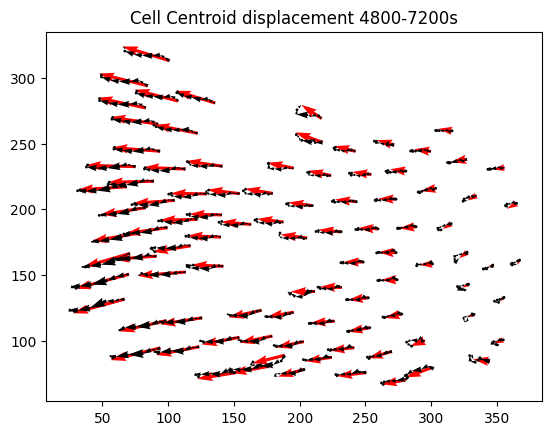

In [130]:

for i in range(len(dcc_o)):
    plt.quiver(cc_o_post[i][:,0], cc_o_post[i][:,1], dcc_o[i][:,0], dcc_o[i][:,1],units='xy', angles='xy', scale=1)
plt.quiver(cc_o_post[0][:,0], cc_o_post[0][:,1], cc_o_post[-1][:,0]-cc_o_post[0][:,0], cc_o_post[-1][:,1]-cc_o_post[0][:,1], color='red',units='xy', angles='xy', scale=1, zorder=0)
#plt.scatter(cc_o_4800[:,0], cc_o_4800[:,1])
#plt.scatter(cc_o_7200[:,0], cc_o_7200[:,1])
plt.gca().set_aspect('equal')
#plt.xlim(-170,200)
plt.title('Cell Centroid displacement 4800-7200s')
plt.savefig(save_dir+'/direct_relax_quiver.png', dpi=300)

In [103]:
cc_t=[]
cc_t.append(cc_o_4800)
for i in range(len(F)):
    cc_t.append((F[i]@cc_t[-1].T).T+dr[i])
cc_t=np.array(cc_t)
dcc_t=cc_t[1:]-cc_t[:-1]

cc_t_tot=(Ftot@cc_o_4800.T).T+drtot 
dcc_t_tot=cc_t_tot-cc_o_4800

cc_t_rel=[]
cc_t_rel.append(cc_4800)
for i in range(len(Frel)):
    cc_t_rel.append((Frel[i]@cc_t_rel[-1].T).T)
cc_t_rel=np.array(cc_t_rel)
dcc_t_rel=cc_t_rel[1:]-cc_t_rel[:-1]

cc_t_tot_rel=(Ftotrel@cc_4800.T).T
dcc_t_tot_rel=cc_t_tot_rel-cc_4800

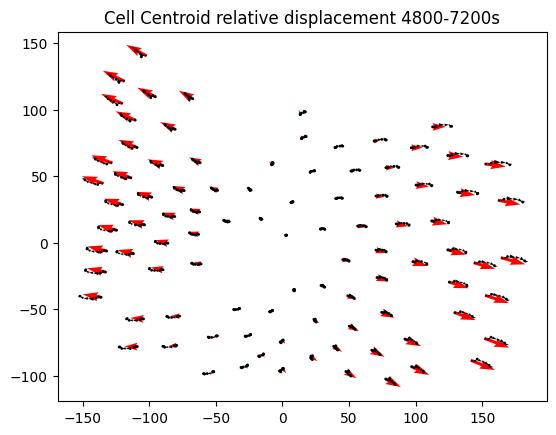

In [105]:

for i in range(len(dcc_t_rel)):
    plt.quiver(cc_t_rel[i][:,0], cc_t_rel[i][:,1], dcc_t_rel[i][:,0], dcc_t_rel[i][:,1],units='xy', angles='xy', scale=1)
plt.quiver(cc_t_rel[0][:,0], cc_t_rel[0][:,1], dcc_t_tot_rel[:,0], dcc_t_tot_rel[:,1], color='red',units='xy', angles='xy', scale=1, zorder=0)
#plt.scatter(cc_o_4800[:,0], cc_o_4800[:,1])
#plt.scatter(cc_o_7200[:,0], cc_o_7200[:,1])
plt.gca().set_aspect('equal')
#plt.xlim(-170,200)
plt.title('Cell Centroid relative displacement 4800-7200s')
plt.savefig(save_dir+'/test_relax_quiver_centred.png', dpi=300)

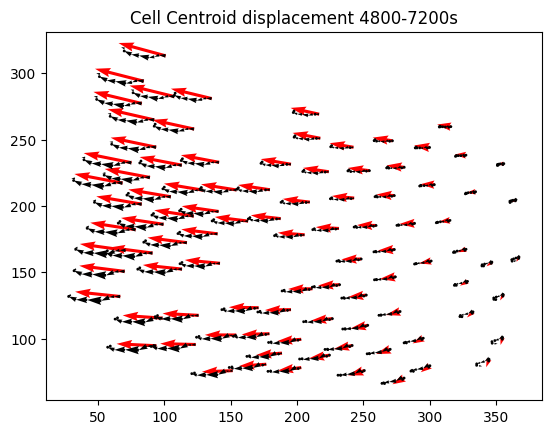

In [127]:

for i in range(len(dcc_t)):
    plt.quiver(cc_t[i][:,0], cc_t[i][:,1], dcc_t[i][:,0], dcc_t[i][:,1],units='xy', angles='xy', scale=1)
plt.quiver(cc_t[0][:,0], cc_t[0][:,1], dcc_t_tot[:,0], dcc_t_tot[:,1], color='red',units='xy', angles='xy', scale=1, zorder=0)
#plt.scatter(cc_o_4800[:,0], cc_o_4800[:,1])
#plt.scatter(cc_o_7200[:,0], cc_o_7200[:,1])
plt.gca().set_aspect('equal')
#plt.xlim(-170,200)
plt.title('Cell Centroid displacement 4800-7200s')
plt.savefig(save_dir+'/fitted_relax_quiver.png', dpi=300)

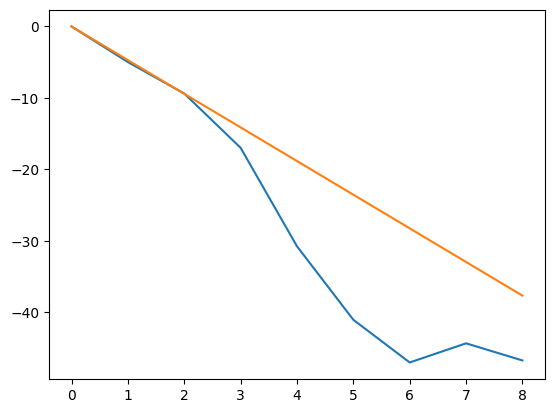

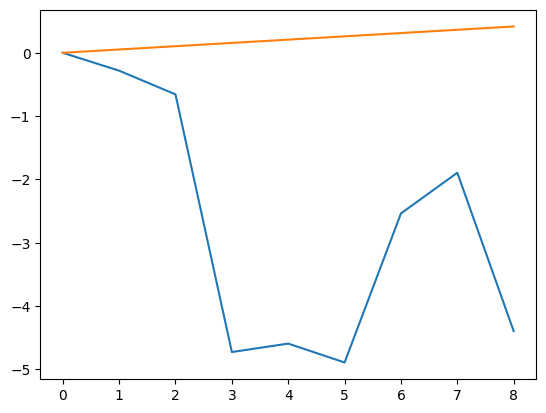

In [123]:
plt.plot(np.cumsum(np.append([0],np.array(dr)[:,0])))
plt.plot([0,8],[0,np.array(drtot)[0]])
plt.show()
plt.plot(np.cumsum(np.append([0],np.array(dr)[:,1])))
plt.plot([0,8],[0,np.array(drtot)[1]])

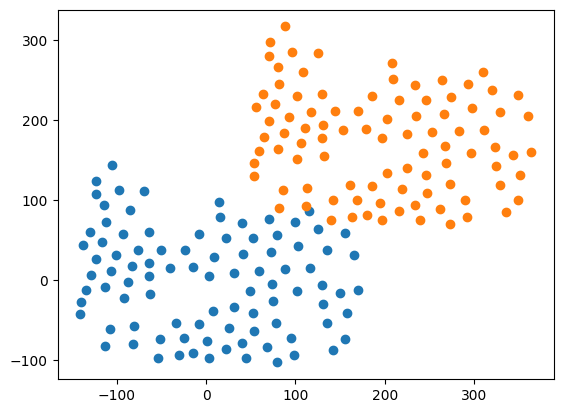

In [46]:
plt.scatter(cc_5700[:,0],cc_5700[:,1] )
plt.scatter(cc_o_5700[:,0],cc_o_5700[:,1] )